In [1]:
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import scipy.io
import matplotlib.pyplot as plt
import math
# from google.colab import files
from random import randrange
from scipy.linalg import block_diag
import time
timestr = time.strftime("%Y%m%d-%H%M%S")
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 13})
import time
from scipy.stats import beta
# from google.colab import files
from datetime import datetime


D=0.4
x01=np.array([-12.9949, -17.4475,  31.0965])

num=38

PH=301


nowstr = datetime.now().strftime("%m-%d-%Y_%H-%M-%S_")
RK4_time=0
unfold_time=0
model_time=0
grad_time=0
traject_time=0
seed = 1  # seed of random numbers
torch.manual_seed(int(seed)) # initialization of seed of random numbers for pytorch
np.random.seed(seed)
# ave=0
# sum=0
# cnt=0

/home/rk-nagai/.local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:


class L63(nn.Module):
    def __init__(self, T, size):
        # もろもろのパラメータを定義
        super(L63, self).__init__()

        # 予測区間の長さ？
        self.predictionHorizon = T

        # モデル予測制御をかける時間の長さ
        self.MPCfinalTime = 8000
        #

        # self.MPCfinalTime = 10

        # number of noise paths used for each iteration
        # self.m = 10
        self.m=10
        self.batchSize = 1
        self.lr =10

        self.xave=1.00
        self.xcnt=1.00
        self.xsum=1.00
        self.relu = nn.ReLU()

        self.before=torch.zeros(3,2000)
        self.step=0
        self.state=torch.zeros(3,self.predictionHorizon)
        self.is_first=1
        
        self.D=size

        # 制御入力の大きさの上限と下限
        # self.umax = umax
        # self.umin = umin

        # システムの初期値
        # self.x0 = torch.tensor(np.array([8.20, 10.08, 23.86]))  # good
        self.x0 = torch.tensor(np.array([0,0,0]))
        self.x1 = torch.tensor(np.array([0,0,0]))
        self.x2 = torch.tensor(np.array([0,0,0]))
        self.x3 = torch.tensor(np.array([0,0,0]))
        self.x4 = torch.tensor(np.array([0,0,0]))
        self.x5 = torch.tensor(np.array([0,0,0]))
        self.x6 = torch.tensor(np.array([0,0,0]))
        self.x7 = torch.tensor(np.array([0,0,0]))
        # for beta distributions...
        # 一様分布
        self.alpha = 1
        self.beta = 1

        # noise の大きさ
        self.minw = -.1
        self.maxw = .1
        # 第二要素にかける数
        self.w2factor = 20

        # いろいろなパラメータ．システムの
        # self.v = nn.Parameter(torch.zeros(1, self.predictionHorizon-1, dtype=torch.double))
        self.v = nn.Parameter(torch.normal(0, 1, size=(3, self.predictionHorizon-1)))
        self.p=torch.tensor(10)
        self.r=torch.tensor(32)
        self.b=torch.tensor(8/3)
        self.Ts = torch.tensor(0.01)

       

    def RK4(self,xold):
        xnew=torch.zeros(3)
        k1=torch.zeros(3)
        k2=torch.zeros(3)
        k3=torch.zeros(3)
        k4=torch.zeros(3)

        k1=self.florenzcontrol(xold)
        k2=self.florenzcontrol(xold+k1*self.Ts/2.)
        k3=self.florenzcontrol(xold+k2*self.Ts/2.)
        k4=self.florenzcontrol(xold+k3*self.Ts)
        
        xnew[0]=xold[0]+self.Ts/6.0*(k1[0]+2.0*k2[0]+2.0*k3[0]+k4[0])
        xnew[1]=xold[1]+self.Ts/6.0*(k1[1]+2.0*k2[1]+2.0*k3[1]+k4[1])
        xnew[2]=xold[2]+self.Ts/6.0*(k1[2]+2.0*k2[2]+2.0*k3[2]+k4[2])
        return xnew

    # self.relu = nn.ReLU()
    # システムを１ステップ進める関数
    def forward(self,x, u):
        self.x0 = self.f(x,u)

    # # 飽和関数
    # def sat(self, v):
    #     return torch.sigmoid(v/20)*(self.umax-self.umin)+self.umin
    #     # return v
        
        
    # def kyoku(self,v):
    #     r=math.sqrt(v[0]*v[0]+v[1]*v[1]+v[2]*v[2])
    #     theta=math.acos(v[2]/r)
    #     fai=math.atan(v[1]/v[0])
    #     xyz=torch.tensor([1.0,2.0,3.0],requires_grad=True)
    #     mask=xyz==1.0
    #     # print(self.D*math.sin(theta)*math.sin(fai))
    #     x=torch.tensor([self.D*math.sin(theta)*math.cos(fai),0.0,0.0])
    #     print(x)
    #     xyz=xyz+mask*(x-xyz)
    #     mask=xyz==2.0
    #     y=torch.tensor([0.0,self.D*math.sin(theta)*math.sin(fai),0.0])
    #     xyz=xyz+mask*(y-xyz)
    #     mask=xyz==3.0
    #     z=torch.tensor([0.0,0.0,self.D*math.cos(theta)])
    #     xyz=xyz+mask*(z-xyz)
        
    #     return xyz
    
    # def kyoku(self,v):
        
    #     r=math.sqrt(v[0].clone()*v[0].clone()+v[1].clone()*v[1].clone()+v[2].clone()*v[2].clone())
    #     theta=math.acos(v[2].clone()/r)
    #     fai=math.atan(v[1].clone()/v[0].clone())
    #     # xyz=torch.tensor([1.0,2.0,3.0],requires_grad=True)
    #     # xyz=torch.zeros_like(v,requires_grad=True)
    #     xyz=torch.tensor([self.D*math.sin(theta)*math.cos(fai),self.D*math.sin(theta)*math.sin(fai),self.D*math.cos(theta)],requires_grad=True)
    #     # xyz[0]=self.D*math.sin(theta)*math.cos(fai)
    #     # xyz[1]=self.D*math.sin(theta)*math.sin(fai)
    #     # xyz[2]=self.D*math.cos(theta)
    #     print(xyz)
        
    #     return xyz
        
    # def kyoku(self,v):
    #     return v
    
    def kyoku(self,v):
        r=math.sqrt(v[0].clone()*v[0].clone()+v[1].clone()*v[1].clone()+v[2].clone()*v[2].clone())
        # xyz=torch.zeros_like(v,requires_grad=True)  
        return v/r*self.D
    
    def florenz(self,x):
        dxyz=torch.zeros_like(x)
        dxyz[0] = -self.p * x[0] + self.p * x[1]
        dxyz[1] = (self.r - x[2]) * x[0] - x[1] 
        dxyz[2] = x[0] * x[1] - self.b * x[2]
        return dxyz

   
    def florenzcontrol(self, x):
        dxyz=torch.zeros_like(x)
        dxyz[0] = -self.p * x[0].clone() + self.p * x[1].clone()
        dxyz[1] = (self.r - x[2].clone()) * x[0].clone() - x[1].clone()
        dxyz[2] = x[0].clone() * x[1].clone() - self.b * x[2].clone()

        return dxyz
    
     # システムの関数 x(k+1) = f(x(k), u(k), w(k))
    def f(self, x, u):
        x1,y1,z1=self.florenzcontrol(x)
        # dx=self.Ts*torch.cat([x1.reshape(1),y1.reshape(1),z1.reshape(1)],0).view(-1,1,1)
        x_next=torch.zeros(3)
        x_next=self.RK4(x)
        x_next[0]=x_next[0]+u[0]
        x_next[1]=x_next[1]+u[1]
        x_next[2]=x_next[2]+u[2]
        
        return x_next


    # quadratic costs
    def stageCost(self, x, u):
            
        cost=self.relu(x[0])
        
        return cost
    
    def finalStageCost(self, x):
        cost=self.relu(x[0])   
        return cost
        

    # ノイズ系列 w が入ってきたときの状態の軌道
    def trajectoryforMPC(self,u):
        x = torch.zeros(3, self.predictionHorizon)
        # t=self.predictionHorizon-1
        x[:, 0] = self.x0.float()+np.random.normal(loc=0,scale=math.sqrt(2),size=3)
            # 最初の時刻の入力は u なので
        x[:, 1] = self.f(x[:, 0], u)
        for i in range(1, self.predictionHorizon-1):
             x[:, i+1] = self.f(x[:, i], self.kyoku(self.v[:, [i]]))
        return x

    # なぞ
    def sampleJforMPC(self, u, T):
        x = self.trajectoryforMPC(u)
        cost = torch.tensor(0)
        for i in range(T-1):
            cost = cost + self.stageCost(x[:, i], self.kyoku(self.v[:, [i]]))
        return cost + self.finalStageCost(x[:, T-1])

    # なぞ
    def sampleBatchJforMPC(self, u, T):
        cost = torch.zeros(( self.batchSize))
        for i in range(self.batchSize):
            cost[i] = self.sampleJforMPC(u, T)
        return cost

    # なぞ
    def unfoldTrainForMPC(self, currentInput):
        opt = optim.Adam(self.parameters(), lr=self.lr)
        self.train()
        loss_func = nn.L1Loss()
        # for T in range(2, self.predictionHorizon+1):
        target = torch.zeros([1,self.batchSize])
        for i in range(self.m):
            opt.zero_grad()
            loss_func(self.sampleBatchJforMPC(currentInput, self.predictionHorizon),target).backward(retain_graph=True)
            opt.step()
        # self.u = self.sat(self.v)





In [3]:
# 実際にモデル予測制御をする関数


def MPC(x0, size):
    predictionHorizon = PH
    cycle=8
    # Model = L63(predictionHorizon, umin, umax)
    # myModel = torch.jit.trace(Model)
    
    myModel = L63(predictionHorizon, size)
    myModel.x0 = torch.tensor(x0)
    x = np.zeros((3, myModel.MPCfinalTime+1))
    u = np.zeros((3, myModel.MPCfinalTime+1))
    for i in range(int((myModel.MPCfinalTime)/cycle)):
        # print(i)
        # x[:, [i]] = myModel.x0.detach().numpy()
        x[:, cycle*i] = myModel.x0.detach().numpy()
        # etime = myModel.unfoldTrainForMPC(u[:, i])
        start=time.time()
        myModel.unfoldTrainForMPC(u[:, [i]])
        end=time.time()
        global unfold_time
        unfold_time+=end-start
        for j in range(cycle):
            u[:, cycle*i+j] = myModel.kyoku(myModel.v[:, j]).detach().numpy()

        # u[0, [i+1]] = myModel.sat(myModel.v[0, [1]]).detach().numpy()
        
        for j in range(cycle):
            myModel.forward(torch.from_numpy(x[:,cycle*i+j].astype(np.float32)).clone(),u[:, cycle*i+j])
            x[:,cycle*i+j+1] = myModel.x0.detach().numpy()
        newx0 = myModel.x0.detach()
        myModel = L63(predictionHorizon, size)
        myModel.x0 = newx0
      
    x[:, myModel.MPCfinalTime] = myModel.x0.detach().numpy()
    return x, u
  



In [4]:
# umin=-0.023094010768
# umax=0.023094010768

 
x1,u1=MPC(x01,D)



print(unfold_time)



/usr/local/lib/python3.8/dist-packages/torch/nn/modules/loss.py:96: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


7347.835319519043


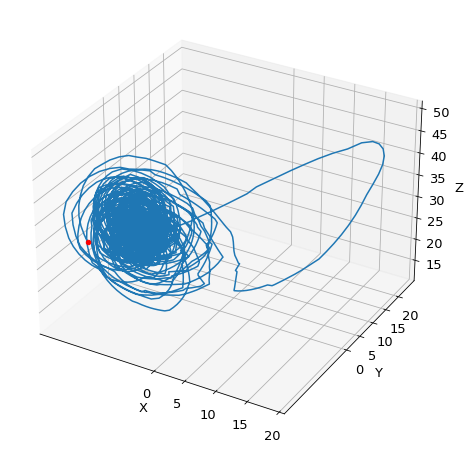

In [5]:
fig = plt.figure(figsize=[8, 8])
ax = fig.add_subplot(projection="3d")
ax.scatter(*x1[:, 0], c="red")
# ax.plot(*x1.transpose())
ax.plot(x1[0],x1[1],x1[2])
plt.xlabel('X')
plt.ylabel('Y')
ax.zlabel=ax.set_zlabel('Z')
plt.xticks([0,5,10,15,20])
plt.yticks([0,5,10,15,20])
plt.savefig(f'paper-D={D}-case{num}-pH={PH}-8000times-T=1.5.png')
plt.show()

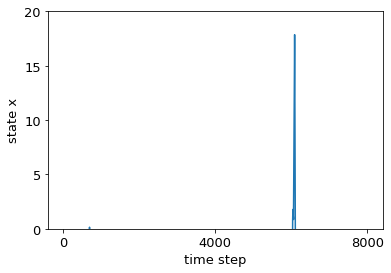

In [6]:
y=np.arange(0,8001)
plt.plot(y,x1[0])
plt.xlabel('time step')
plt.ylabel('state x')
plt.ylim(0,20)
plt.xticks([0,4000,8000])
plt.yticks([0,5,10,15,20])
plt.savefig(f'paper-state-x-D={D}-case{num}-pH={PH}-8000times-T=1.5.png')


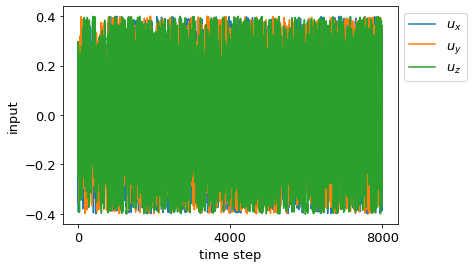

<Figure size 432x288 with 0 Axes>

In [7]:
y=np.arange(0,8001)

fig = plt.figure(figsize = (6,4))

plt.plot(y, u1[0],  label='$u_x$')
plt.plot(y, u1[1],  label='$u_y$')
plt.plot(y, u1[2],  label='$u_z$')


#ラベルを追加
plt.xlabel('time step')
plt.ylabel('input')
# plt.ylim(-0.3,0.3)
plt.xticks([0,4000,8000])
# plt.yticks([0,5,10,15,20])

# 凡例表示
# plt.legend(loc = 'upper right') 
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))



plt.show()

plt.savefig(f'paper-input-D={D}-case{num}-pH={PH}-8000times-T=1.5.png')